<a href="https://colab.research.google.com/github/sammymilitante/Modelsim/blob/master/Train_03_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Purpose:**
Covid-19 started in November 2019 and started to spread across the world killing 3.74 million people. To curb the spread were to wear masks and maintain 6 feet distance. Although vaccines are available now and the cases have come down in some few countries, many countries are still struggling. In order to aid in stopping the spread and identify individuals not following the safety policies, we aim to build an Object Detection and Convolution Neural Network based face mask and social distance detection system. The dataset to be used contains numerous images of instances where people are with and without mask and the model aims to identify people violating safety policies and flag the images with violation concerns.

# 0. Import Libraries

In [ ]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D

import matplotlib.pylab as plt

import os

# 1. Read the the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/CNN/data_set"

train  validation


In [ ]:
num_classes=2
img_rows,img_cols=48,48
batch_size=64

train_data_dir='/content/drive/My Drive/Colab Notebooks/CNN/data_set/train'
validation_data_dir='/content/drive/My Drive/Colab Notebooks/CNN/data_set/validation'

train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)
					
validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

model = Sequential()


Found 28 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


# 2. Fit the model

In [ ]:
#Block-1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block-4 

# model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
# model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

#Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

# 3. Train the model

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from time import time

# checkPointName = 'EmotionDetectionModel.h5'
#quick fix to increment the file if it exists
counter = 0
filename = "EmotionDetectionModel{}.h5"
while os.path.isfile(filename.format(counter)):
    counter += 1
checkPointName = filename.format(counter)
#quick fix to increment the file if it exists

checkpoint = ModelCheckpoint(checkPointName,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=5000,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                              factor=0.2,
                              patience=5000,
                              verbose=1,
                              min_delta=0.0001)

# Create a TensorBoard instance with the path to the logs directory
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

callbacks = [earlystop,checkpoint,reduce_lr, tensorboard]
''', tensorboard'''

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

nb_train_samples = 71
nb_validation_samples = 22
epochs=100

history=model.fit_generator(
                train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=nb_validation_samples//batch_size).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.5357
Epoch 1: saving model to EmotionDetectionModel2.h5
1/1 [==============================] - 6s 6s/step - loss: 1.3559 - accuracy: 0.5357 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.4286
Epoch 2: saving model to EmotionDetectionModel2.h5
1/1 [==============================] - 2s 2s/step - loss: 1.6198 - accuracy: 0.4286 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7500
Epoch 3: saving model to EmotionDetectionModel2.h5
1/1 [==============================] - 1s 786ms/step - loss: 0.6084 - accuracy: 0.7500 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.4690 - accuracy: 0.3929
Epoch 4: saving model to EmotionDetectionModel2.h5
1/1 [==============================] - 1s 771ms/step - loss: 1.4690 - accuracy: 0.3929 - lr: 0.0010
Epoch 5/100
1/1 [=============

Plot

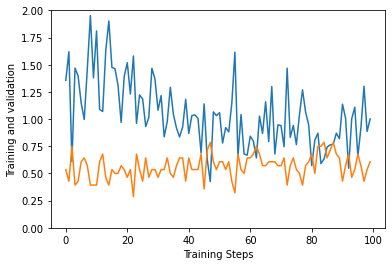

In [ ]:
plt.figure()
plt.ylabel("Training and validation")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["accuracy"])

#plt.figure()
#plt.ylabel("Accuracy (training and validation)")
#plt.xlabel("Training Steps")
#plt.ylim([0,1])
#plt.plot(history["accuracy"])
#plt.plot(history["val_accuracy"])